In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim import SGD, lr_scheduler, Optimizer

from torchvision import transforms, models
from torchvision.utils import make_grid

from matplotlib import pyplot as plt
from tqdm.auto import tqdm
from sklearn import metrics

from PIL import Image
import os
import time
import copy

### Modelo

In [2]:
weights = models.ResNet18_Weights.DEFAULT
preprocessing = weights.transforms()

net = models.resnet18(weights=weights)

for param in net.parameters():
    param.requires_grad = False

n_classes = 2
num_ft = net.fc.in_features
net.fc = nn.Linear(num_ft, n_classes)

optimizer = SGD(net.fc.parameters(), lr=1e-3, momentum=0.9)
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

### Data

In [3]:
class FoldersDataset(Dataset):
    
    def __init__(self,
                 images_folders: list,
                 transform=None,
                 format_filter = ('.jpg', '.jpeg', '.png')):
        super().__init__()
        
        self.data_filepaths = []
        self.data_labels = []
        
        for num_class, class_folder in enumerate(images_folders):
            
            corrupted_images = []
            for image_filename in os.listdir(class_folder):
                image_path = os.path.join(class_folder, image_filename)
                
                if os.path.splitext(image_path)[-1] in format_filter:
                    try:
                        image = Image.open(image_path)
                    except:
                        corrupted_images.append(image_filename)
                    else:
                        self.data_filepaths.append(image_path)
                        self.data_labels.append(num_class)
            
            if len(corrupted_images) > 0:
                print(f'{len(corrupted_images)} corrupted image(s) in {class_folder}:')   
                for file in corrupted_images:
                    print(f'- {file}')
        
        self.transform = transform
        
    def __len__(self):
        return len(self.data_filepaths)
    
    def __getitem__(self, index):
        image = Image.open(self.data_filepaths[index])
        label = self.data_labels[index]
        
        if self.transform:
            image = self.transform(image)
        
        return image, label

In [4]:
def to_rgb(image):
    image = transforms.ToTensor()(image)
    if image.shape[0] == 1:
        return image.expand(3, -1, -1)
    if image.shape[0] > 3:
        return image[0:3]
    return image

augmentation = transforms.Compose([transforms.RandomHorizontalFlip(),
                                   transforms.RandomRotation(30)])

dataset = FoldersDataset(['data/dogs', 'data/cats'], transform = transforms.Compose([to_rgb, preprocessing, augmentation]))
labels = 'dog cat'.split()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


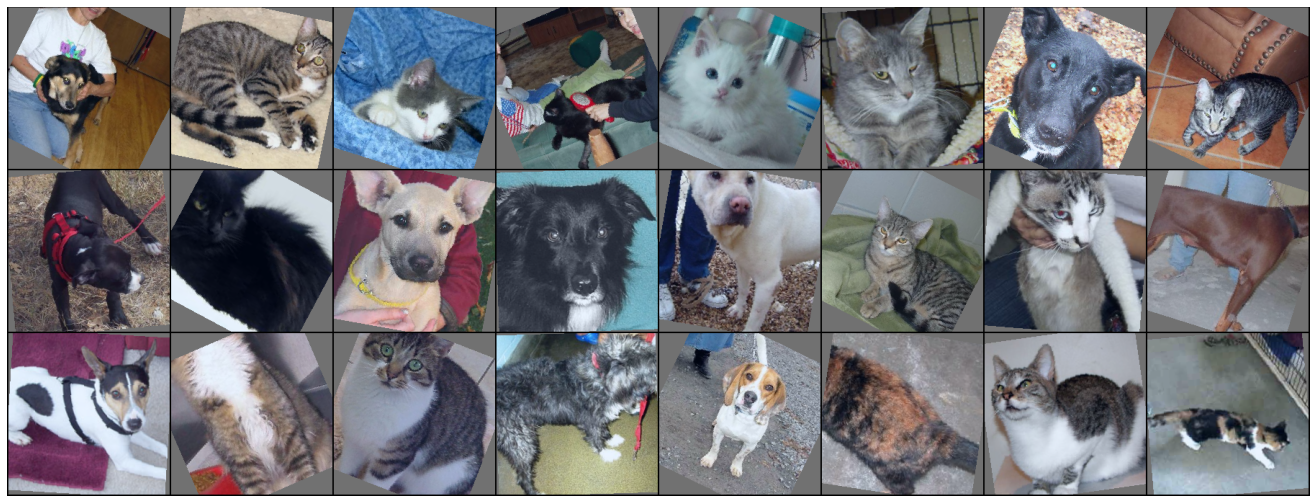

In [5]:
def dataset_show(dataset, n=24, shuffle=True):
    
    plt.figure(figsize=(24, -3*(n//-8)))
    
    if shuffle:
        indices = torch.randint(0, len(dataset), [n])
    else:
        indices = range(n)
    
    images = [dataset[i][0] for i in indices]
    images_grid = make_grid(images, normalize=True)
    plt.imshow(images_grid.permute(1,2,0))
    plt.axis('off')
    plt.show()
    
dataset_show(dataset)

In [6]:
def split_dataset(dataset, train_ratio, dev_ratio):
    n = len(dataset)
    n_train, n_dev = int(n*train_ratio), int(n*dev_ratio)
    n_test = n - n_train - n_dev
    return random_split(dataset, [n_train, n_dev, n_test])

dataset_train, dataset_dev, _ = split_dataset(dataset, train_ratio=0.7, dev_ratio=0.3)

In [7]:
dataloader_train = DataLoader(dataset_train, batch_size=64)
dataloader_dev = DataLoader(dataset_dev, batch_size=64)
dataloaders = {'train': dataloader_train, 'dev': dataloader_dev}

### Entrenamiento

In [8]:
class Trainer:

    def __init__(self,
                 net: nn.Module,
                 optimizer: Optimizer,
                 scheduler: lr_scheduler._LRScheduler = None):

        # PyTorch objects:
        self.net = net
        self.optimizer = optimizer
        self.scheduler = scheduler
        
        # Default configuration:
        self.loss_fn = nn.CrossEntropyLoss()
        self.metric = metrics.accuracy_score
        self.metric_criterion = 'max'  # better models have higher metric value.
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.least_improvement = 0.01  # the new metric value must be at least 1% better to update parameters.
        self.verbose_step = 1

        # Training stats:
        self.losses = {'train': [], 'dev': []}
        self.metric_values = {'train': [], 'dev': []}
        self.best_states = {
            'net': None,
            'optimizer': None,
            'scheduler': None,
            'epoch': 0,
            'metric_value': float('-inf')
            }
        self.training_time = 0

    def save_training(self, file: str) -> None:
        states = dict()
        for attr_key in vars(self).keys():
            attr_value = getattr(self, attr_key)
            if attr_key in ('net', 'optimizer', 'scheduler'):  # for PyTorch objects, only the states will be saved.
                states[attr_key] = attr_value.state_dict() if attr_value else attr_value  # object may not be defined.
            else:
                states[attr_key] = attr_value
        torch.save(states, file)

    def load_training(self, file: str) -> None:
        states = torch.load(file)
        for attr_key in vars(self).keys():
            if attr_key in ('net', 'optimizer', 'scheduler'):
                attr_value = getattr(self, attr_key)
                if attr_value and states[attr_key]:  # the attribute is defined and there is an associated saved state.
                    attr_value.load_state_dict(states[attr_key])
            else:
                attr_value = states[attr_key]
            setattr(self, attr_key, attr_value)

    def last_epoch(self) -> int:
        return len(self.losses['train'])

    def plot_training(self) -> None:
        
        if self.best_states['epoch'] == 0:
            print('No training record.')
            return
        
        metric_name = self.metric.__name__.removesuffix('_score')
        total_epochs = self.last_epoch()
        stats = {'Loss': self.losses, metric_name.capitalize(): self.metric_values}
        epochs = list(range(1, total_epochs + 1))

        fig, ax = plt.subplots(1, len(stats), figsize=(15, 5))
        for idx, key in enumerate(stats.keys()):
            ax[idx].plot(epochs, stats[key]['train'], label='train')
            ax[idx].plot(epochs, stats[key]['dev'], label='validation')
            ax[idx].axvline(x=self.best_states['epoch'], color='r', linestyle='--', 
                            label=f'best {metric_name}', alpha=0.8)
            ax[idx].set_title(f'Epochs vs. {key}')
            ax[idx].set_xlabel('epoch')
            ax[idx].set_ylabel(key)
            ax[idx].legend()
            # Grid:
            ax[idx].grid()
            plt_num_ticks = 15  # max number of epochs ticks on the plot.
            epoch_nums = list(range(total_epochs, 0, (total_epochs//-plt_num_ticks)))
            ax[idx].set_xticks(epoch_nums[::-1], minor=False)
            ax[idx].xaxis.grid(True, which='major', linestyle='--')
            if key == metric_name.capitalize():
                ax[idx].set_ylim([0, 1.1])
                ax[idx].set_yticks([i/10 for i in range(0,11)], minor=False)
                ax[idx].yaxis.grid(True, which='major', linestyle='--')
        fig.tight_layout()

    def train(self, dataloaders: dict, epochs: int, early_stopping: int = None) -> None:

        # Progress bar (only for training mode):
        initial_epoch = self.last_epoch()
        def progress_bar(dataloader, epoch, mode):
            if mode == 'train':
                bar_format = f'Epoch {initial_epoch + epoch}/{initial_epoch + epochs} ' \
                             '{l_bar}{bar}| batch {n_fmt} of {total_fmt} ({rate_fmt}) ' \
                             '- training time: {elapsed}'
                return tqdm(dataloader, unit=' batches', bar_format=bar_format)
            else:
                return dataloader
        
        # Training:
        self.net.to(self.device)
        metric_name = self.metric.__name__.removesuffix('_score')
        initial_training_time = time.time()
        early_stopping_patience = 0
        try:
            for epoch in range(1, epochs + 1):

                for mode in ('train', 'dev'):
                    self.net.train(mode == 'train')
                    dataloader = progress_bar(dataloaders[mode], epoch, mode)

                    # Forward and backward:
                    epoch_loss = 0.0
                    dataloader_labels = {'true': [], 'pred': []}
                    with torch.set_grad_enabled(mode == 'train'):
                        for x, y in dataloader:
                            x, y = x.to(self.device), y.to(self.device)
                            output = self.net(x)
                            loss = self.loss_fn(output, y)

                            if mode == 'train':
                                self.optimizer.zero_grad()
                                loss.backward()
                                self.optimizer.step()
                            
                            epoch_loss += loss * x.size(0)
                            y_pred = torch.argmax(output, dim=1)
                            
                            # Dataloader labels for metric evaluation:
                            dataloader_labels['true'] += y.tolist()
                            dataloader_labels['pred'] += y_pred.tolist()

                    if mode == 'train' and self.scheduler:
                        self.scheduler.step()
                    
                    # Metrics backup:
                    epoch_loss /= len(dataloaders[mode].dataset)
                    epoch_metric = self.metric(dataloader_labels['true'],
                                               dataloader_labels['pred'])
                    self.losses[mode].append(epoch_loss.item())
                    self.metric_values[mode].append(epoch_metric)

                    # Verbose:
                    if self.verbose_step and epoch % self.verbose_step == 0:
                        print(f'- {mode:5} | loss: {epoch_loss:.4f}',
                              f'- {metric_name}: {epoch_metric:.4f}')

                # Best model update:
                sgn = 1 if self.metric_criterion == 'max' else -1  # maximize (+1) or minimize (-1) the metric.
                improvement_threshold = self.best_states['metric_value'] \
                                        * (1 + sgn * self.least_improvement)
                if sgn * epoch_metric >= sgn * improvement_threshold:
                    early_stopping_patience = 0 
                    for key in ('net', 'optimizer', 'scheduler'):
                        value = getattr(self, key)
                        state = value.state_dict() if value else value
                        self.best_states[key] = copy.deepcopy(state)
                    self.best_states['epoch'] = epoch
                    self.best_states['metric_value'] = epoch_metric
                else:
                    early_stopping_patience += 1
                    if early_stopping_patience == early_stopping:
                        print(f'\nEarly stopping criterion reached.',
                              f'The model improved less than {self.least_improvement * 100}%',
                              f'in the last {early_stopping} epochs.')
                        break

        except KeyboardInterrupt:
            print('Interrupted training. Last epoch stats will not be saved.')
            # Clip last stats to the shortest one:
            last_valid_epoch = len(self.metric_values['dev'])
            for mode in ('train', 'dev'):
                self.losses[mode] = self.losses[mode][:last_valid_epoch]
                self.metric_values[mode] = self.metric_values[mode][:last_valid_epoch]

        # Post-training:
        
        if self.last_epoch() == 0:
            return  # nothing will print.
        
        current_training_time = time.time() - initial_training_time
        self.training_time += current_training_time

        if self.verbose_step:
            print(f'\nBest {metric_name} value reached at epoch {self.best_states["epoch"]}',
                    f'with a value of {self.best_states["metric_value"]}.')
            formatted_time = lambda t: time.strftime('%-H h, %-M min, %-S sec', # add %-j for days.
                                                     time.gmtime(t))
            print(f'Training time: {formatted_time(current_training_time)}.')
            if self.training_time > current_training_time:
                print(f'Accumulated training time: {formatted_time(self.training_time)}.')
        
        # Notification:
        title = f'Finished training'
        text = f'Final {metric_name}: {self.best_states["metric_value"]:.2f}' + \
               f'\nLast epoch: {self.best_states["epoch"]}'
        os.system(f"""osascript -e 'display notification "{text}" with title "{title}"'""")

Epoch 1/30 100%|██████████| batch 274 of 274 ( 2.16s/ batches) - training time: 09:52


- train | loss: 0.1747 - accuracy: 0.9332


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.1074 - accuracy: 0.9599


Epoch 2/30 100%|██████████| batch 274 of 274 ( 2.43s/ batches) - training time: 11:06


- train | loss: 0.1095 - accuracy: 0.9592


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0938 - accuracy: 0.9631


Epoch 3/30 100%|██████████| batch 274 of 274 ( 2.44s/ batches) - training time: 11:09


- train | loss: 0.1027 - accuracy: 0.9598


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0850 - accuracy: 0.9677


Epoch 4/30 100%|██████████| batch 274 of 274 ( 2.42s/ batches) - training time: 11:02


- train | loss: 0.0959 - accuracy: 0.9636


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0824 - accuracy: 0.9675


Epoch 5/30 100%|██████████| batch 274 of 274 ( 2.34s/ batches) - training time: 10:40


- train | loss: 0.0960 - accuracy: 0.9622


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0781 - accuracy: 0.9705


Epoch 6/30 100%|██████████| batch 274 of 274 ( 2.59s/ batches) - training time: 11:48


- train | loss: 0.0921 - accuracy: 0.9634


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0788 - accuracy: 0.9679


Epoch 7/30 100%|██████████| batch 274 of 274 ( 2.59s/ batches) - training time: 11:48


- train | loss: 0.0929 - accuracy: 0.9638


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0753 - accuracy: 0.9693


Epoch 8/30 100%|██████████| batch 274 of 274 ( 2.55s/ batches) - training time: 11:37


- train | loss: 0.0873 - accuracy: 0.9657


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0768 - accuracy: 0.9695


Epoch 9/30 100%|██████████| batch 274 of 274 ( 2.74s/ batches) - training time: 12:31


- train | loss: 0.0882 - accuracy: 0.9649


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0761 - accuracy: 0.9708


Epoch 10/30 100%|██████████| batch 274 of 274 ( 2.88s/ batches) - training time: 13:09


- train | loss: 0.0872 - accuracy: 0.9657


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/PIL/TiffImagePlugin.py:822: UserWarning: Truncated File Read
  warnings.warn(str(msg))


- dev   | loss: 0.0755 - accuracy: 0.9712

Early stopping criterion reached. The model improved less than 1.0% in the last 5 epochs.

Best accuracy value reached at epoch 5 with a value of 0.9705294039205228.
Training time: 2 h, 43 min, 16 sec.


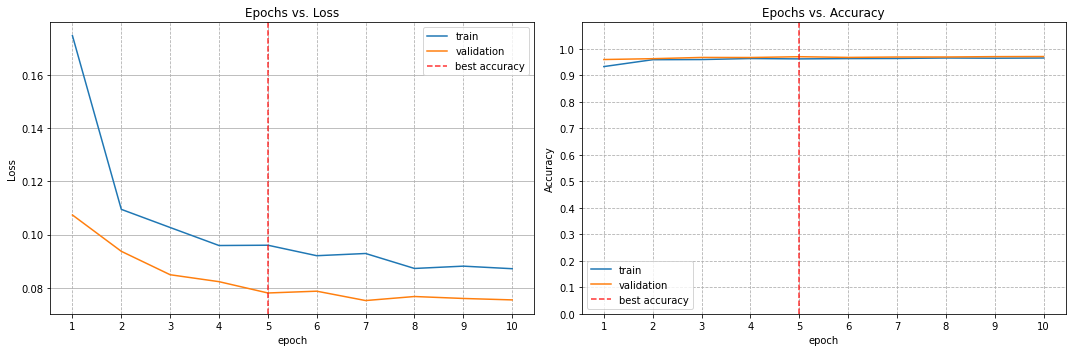

In [9]:
trainer = Trainer(net, optimizer, scheduler)
trainer.train(dataloaders, epochs=30, early_stopping=5)
#trainer.load_training('model_training.pt')
trainer.save_training('model_training.pt')
trainer.plot_training()

In [10]:
def predict_dataset(net, dataset, n=5, random=True, unnormalize=None, classes_names=None):
    
    net.eval()
    
    if n == 'all':
        n = len(dataset)
    
    rows, cols = -(n//-8), 8

    fig = plt.figure(figsize=(3*cols, 3*rows))
    plt.tight_layout()
    
    corrects = 0.0
    for i in range(n):
        index = torch.randint(0, len(dataset), [1]).item() if random else i
        image, label = dataset[index]
        pred = net(image.unsqueeze(0)).argmax(dim=1).item()
        
        if classes_names:
            label = classes_names[label]
            pred = classes_names[pred]
        
        if unnormalize == 'imagenet':
            mean, std = torch.tensor([(0.485, 0.456, 0.406), (0.229, 0.224, 0.225)])
        elif unnormalize:
            mean, std = unnormalize
        else:
            mean, std = 0, 1
    
        image = image.permute(1, 2, 0) * std + mean
        
        fig.add_subplot(rows, cols, i + 1)
        plt.imshow(image)
        plt.axis('off')
        if label == pred:
            corrects += 1
            plt.title(f'{label}', color='g', fontweight='bold')
        else:
            plt.title(f'pred: {label} - label: {pred}', color='r', fontweight='bold')
    accuracy = corrects / n * 100
    print(f'Accuracy: {accuracy:.2f}%')
        

Accuracy: 76.92%


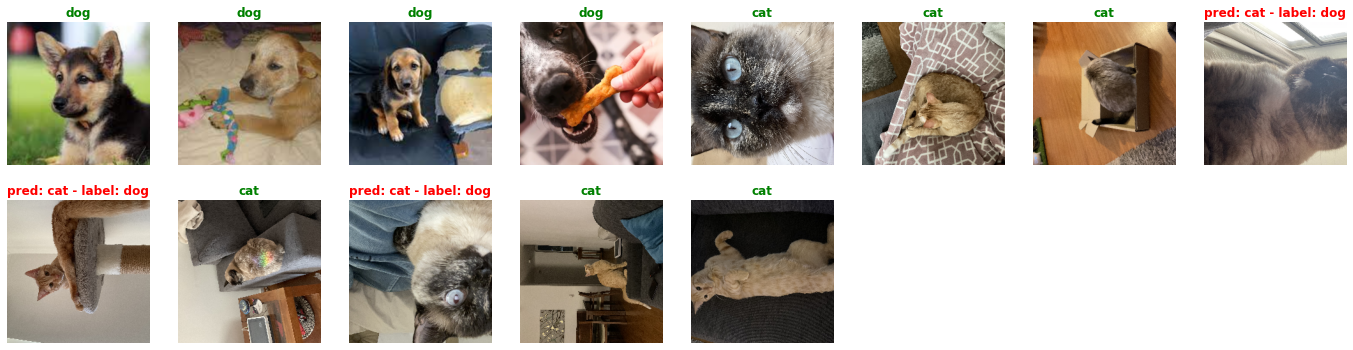

In [11]:
dataset_testing = FoldersDataset(['data/testing/dogs', 'data/testing/cats'], transform = transforms.Compose([to_rgb, preprocessing]))
predict_dataset(net, dataset_testing, n='all', unnormalize='imagenet', classes_names=labels, random=False)